| What you want     | `gate_cfg` (anomaly gate) | `WeightConfig.gate_mode` (share gate) |
| ----------------- | ------------------------- | ------------------------------------- |
| No gate at all    | `None`                    | `None`                                |
| Share gate only   | `None`                    | `"zscore"` or `"percentile"`          |
| Anomaly gate only | `GateConfig(...)`         | `None`                                |
| Both gates        | `GateConfig(...)`         | `"zscore"` / `"percentile"`           |


# Load

In [1]:
import pandas as pd
from plot_triad import plot_triad_eop
from itertools import permutations

from eop_post_cf_plus import anomalies_from_pred, AnomalyConfig, WeightConfig, GateConfig, compute_eop

In [2]:
policies_CL = [
    ("2021-04-01", "Ley 21325 \nApril 2021", "red"),
    ("2021-03-01", "US Policy", "yellow")
]

policies_PE = [
    ("2019-07-15", "Visa Requirement\nJune 2019", "Red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2021-07-01", "Temporary Permit Carnet (CPT)\nJuly 2021", "green"),
    ("2021-10-22", "CPT Implementation\nOctober 2021", "red")
]

policies_EC = [
    ("2019-07-25", "Presidential Decree 826\nJuly 2019", "red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2019-08-26", "VIRTE\nBefore July 2019", "blue"),
    ("2022-06-01", "VIRTE\nSep 2022 to Aug 2023", "blue")
]

In [3]:
# ---- 1) Paths (EDIT THESE) ----
pred_path = "/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF.csv"   
flows_path = "/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/df_flow.csv" 
train_end = "2021-12-01"     # training window end used by CF++

# ---- 2) Load ----
pred = pd.read_csv(pred_path)
flows = pd.read_csv(flows_path)
pred

,orig,dest,month,flow,mu_hat,excess_pct
0,AR,BO,2019-01-01,3325.0,1410.899549,1.356653
1,AR,BO,2019-02-01,3275.0,1609.262413,1.035094
2,AR,BO,2019-03-01,2686.0,1776.958044,0.511572
3,AR,BO,2019-04-01,2089.0,1646.620301,0.268659
4,AR,BO,2019-05-01,2084.0,1644.943964,0.266912
...,...,...,...,...,...,...
20155,VE,UY,2022-08-01,122.0,283.244791,-0.569277
20156,VE,UY,2022-09-01,121.0,276.464534,-0.562331
20157,VE,UY,2022-10-01,161.0,341.360665,-0.528358
20158,VE,UY,2022-11-01,149.0,271.568473,-0.451335


In [4]:
# # !!!!!!!!!? don't understand
# pred_anom = anomalies_from_pred(pred, AnomalyConfig(train_end="2021-12-01"))
# pred_anom

,orig,dest,month,flow,mu_hat,excess_pct,z_std
0,AR,BO,2019-01-01,3325.0,1410.899549,1.356653,4.047579
1,AR,BO,2019-02-01,3275.0,1609.262413,1.035094,3.298161
2,AR,BO,2019-03-01,2686.0,1776.958044,0.511572,1.712868
3,AR,BO,2019-04-01,2089.0,1646.620301,0.268659,0.865919
4,AR,BO,2019-05-01,2084.0,1644.943964,0.266912,0.859851
...,...,...,...,...,...,...,...
20155,VE,UY,2022-08-01,122.0,283.244791,-0.569277,-0.760998
20156,VE,UY,2022-09-01,121.0,276.464534,-0.562331,-0.742660
20157,VE,UY,2022-10-01,161.0,341.360665,-0.528358,-0.775379
20158,VE,UY,2022-11-01,149.0,271.568473,-0.451335,-0.590769


# Anomalies

In [9]:
# ---- 3) Anomalies (Z or percent excess) ----
anom_cfg = AnomalyConfig(train_end=train_end, eps=1.0, use_standardized=True)  # Z by default
pred_anom = anomalies_from_pred(pred, anom_cfg)
print("Estimated phi_hat:", pred_anom.attrs.get('phi_hat'))
pred_anom

Estimated phi_hat: 158.5048897277346


,orig,dest,month,flow,mu_hat,excess_pct,z_std
0,AR,BO,2019-01-01,3325.0,1410.899549,1.356653,4.047579
1,AR,BO,2019-02-01,3275.0,1609.262413,1.035094,3.298161
2,AR,BO,2019-03-01,2686.0,1776.958044,0.511572,1.712868
3,AR,BO,2019-04-01,2089.0,1646.620301,0.268659,0.865919
4,AR,BO,2019-05-01,2084.0,1644.943964,0.266912,0.859851
...,...,...,...,...,...,...,...
20155,VE,UY,2022-08-01,122.0,283.244791,-0.569277,-0.760998
20156,VE,UY,2022-09-01,121.0,276.464534,-0.562331,-0.742660
20157,VE,UY,2022-10-01,161.0,341.360665,-0.528358,-0.775379
20158,VE,UY,2022-11-01,149.0,271.568473,-0.451335,-0.590769


In [4]:
# selected_countries = ["VE", "CL", "US", "EC", "CO"]  # 2-letter ISO codes

selected_countries = [
    # South America
    'AR',  # Argentina
    'BO',  # Bolivia
    'BR',  # Brazil
    'CL',  # Chile
    'CO',  # Colombia
    'EC',  # Ecuador
    # 'GY',  # Guyana
    # 'PY',  # Paraguay
    'PE',  # Peru
    # 'SR',  # Suriname
    # 'UY',  # Uruguay
    'VE',  # Venezuela

    # # Central America
    # 'BZ',  # Belize
    'CR',  # Costa Rica
    # 'SV',  # El Salvador
    # 'GT',  # Guatemala
    # 'HN',  # Honduras
    'NI',  # Nicaragua
    'PA',  # Panama

    # Mexico
    'MX',  # Mexico

    # Caribbean (Latin)
    'CU',  # Cuba
    'DO',  # Dominican Republic
    # 'PR',  # Puerto Rico (US territory but culturally Latin)
    'HT',  # Haiti (French/Creole-speaking, sometimes included)

    # Manually add US & CA
    'US','CA','ES'
]

countries = set(selected_countries) 
len(countries)

18

In [5]:
# Generate all 3-country combinations
triads = list(permutations(countries, 3))

# triads[:5]
len(triads) 

4896

In [27]:
# ---- 4) Triads & windows ----
triads = [
    ("VE","CL","US"),
    ("VE","PE","US"),
    ("VE","EC","US"),
    ("VE","CO","US"),
    ("CO","VE","US"),
    ("CR","NI","US"),
    ("HT","DO","US"),

    
    # add more, e.g. ("HTI","DOM","USA"), ("SYR","TUR","DEU")
]

In [28]:
windows = [
    # Basic windows (no share gating), with 3-month smoothing for w
    # WeightConfig(window="m12_24", smooth_ma=3, 
    #              gate_mode=None, 
    #              label="m12_24|ma3", train_end=train_end),
                 
    # # Optional share gating: only count w when the window-mean share is "unusually high"
    # # z-score gate 
    # WeightConfig(window="m12_24", smooth_ma=3, gate_mode="zscore", z_thresh=1.0,
    #              label="m12_24|z≥1.0|ma3", train_end=train_end),
    # percentile-based gate (top 10% of baseline months)
    WeightConfig(window="m12_24", smooth_ma=3, gate_mode="percentile", perc_thresh=0.80,
                 label="m12_24|p80|ma3", train_end=train_end),
]

# '''
# window option: upto_12, m6_18, m12_24
# gate_mode: percentile (perc_thresh), zscore (z_thresh)
# label: m12_24|p90|ma3
# '''

In [30]:
# 5)  Upstream / Downstream gates
# a) Downstream-only (require j->k to be anomalous), hard gate at Z>=1
gate_ds = GateConfig(use_downstream_anom=True, use_upstream_anom=False, z_thresh_jk=1.0)

# b) Upstream-only (require i->j to be anomalous), hard gate at Z>=0.5
gate_us = GateConfig(use_downstream_anom=False, use_upstream_anom=True, z_thresh_ij=0.5)

# c) Both with AND (strict), soft ramp
gate_both = GateConfig(use_downstream_anom=True, use_upstream_anom=True,
                       logic="and", z_thresh_jk=1.0, z_thresh_ij=0.5, soft=True)

In [31]:
# ---- 6) Compute EOP ---- (pick one gate to apply)
# eop_ds   = compute_eop(pred_anom, flows, triads, windows, anomaly_kind="z_std", gate_cfg=gate_ds) # or anomaly_kind: 'excess_pct'
# eop_us   = compute_eop(pred_anom, flows, triads, windows, anomaly_kind="z_std", gate_cfg=gate_us)
eop_both = compute_eop(pred_anom, flows, triads, windows, anomaly_kind="z_std", gate_cfg=gate_both)

# eop = compute_eop(pred_anom, flows, triads, 
#                   windows=[WeightConfig(window="m12_24", gate_mode=None)], 
#                   anomaly_kind="z_std", gate_cfg=None)

# eop.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/0922_eop_results.csv", index=False)
# print("Saved: eop_results.csv")

# eop = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/0915_eop_results.csv")
# eop

In [26]:
eop.sort_values(by="EOP", ascending=True)

,i,j,k,label,window,month,flow_jk,mu_hat_jk,anom_jk,w_ij,EOP,year
73727,CO,VE,PE,m12_24,m12_24,2022-12-01,5087.0,18723.423415,-7.915649,0.545073,-4.314605,2022
73725,CO,VE,PE,m12_24,m12_24,2022-10-01,4317.0,16123.288953,-7.385251,0.553337,-4.086536,2022
73719,CO,VE,PE,m12_24,m12_24,2022-04-01,5088.0,16216.342578,-6.941170,0.579322,-4.021172,2022
73722,CO,VE,PE,m12_24,m12_24,2022-07-01,3244.0,13187.354394,-6.877534,0.560040,-3.851692,2022
73723,CO,VE,PE,m12_24,m12_24,2022-08-01,3408.0,13378.335817,-6.846796,0.560258,-3.835975,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
11950,CR,NI,US,m12_24,m12_24,2022-11-01,16742.0,2325.700863,23.744090,0.492334,11.690018,2022
62447,VE,CO,US,m12_24,m12_24,2022-12-01,31307.0,10205.475910,16.591126,0.729764,12.107614,2022
62444,VE,CO,US,m12_24,m12_24,2022-09-01,25546.0,7117.501902,17.350213,0.700594,12.155462,2022
62445,VE,CO,US,m12_24,m12_24,2022-10-01,29362.0,8788.234574,17.431776,0.706045,12.307614,2022


In [32]:
eop_both.sort_values(by="EOP", ascending=True)

,i,j,k,label,window,month,flow_jk,mu_hat_jk,anom_jk,w_ij,EOP
192,CO,VE,US,"m12_24|p80|ma3|A:dj≥1,ui≥0.5,and,soft",m12_24,2019-01-01,4133.0,5039.426173,-1.014193,0.000000,-0.000000
180,VE,CO,US,"m12_24|p80|ma3|A:dj≥1,ui≥0.5,and,soft",m12_24,2022-01-01,11710.0,8588.649717,2.675215,0.000000,0.000000
179,VE,CO,US,"m12_24|p80|ma3|A:dj≥1,ui≥0.5,and,soft",m12_24,2021-12-01,6976.0,5582.040325,1.481946,0.000000,0.000000
178,VE,CO,US,"m12_24|p80|ma3|A:dj≥1,ui≥0.5,and,soft",m12_24,2021-11-01,10032.0,6962.996023,2.921313,0.000000,0.000000
177,VE,CO,US,"m12_24|p80|ma3|A:dj≥1,ui≥0.5,and,soft",m12_24,2021-10-01,10567.0,6969.214582,3.423119,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
271,CR,NI,US,"m12_24|p80|ma3|A:dj≥1,ui≥0.5,and,soft",m12_24,2021-08-01,5190.0,1774.399792,6.440506,0.188735,1.051204
231,CO,VE,US,"m12_24|p80|ma3|A:dj≥1,ui≥0.5,and,soft",m12_24,2022-04-01,10303.0,7470.566785,2.602924,0.574019,1.494128
230,CO,VE,US,"m12_24|p80|ma3|A:dj≥1,ui≥0.5,and,soft",m12_24,2022-03-01,13798.0,6835.155166,6.689462,0.567938,3.799198
228,CO,VE,US,"m12_24|p80|ma3|A:dj≥1,ui≥0.5,and,soft",m12_24,2022-01-01,18766.0,7259.012253,10.727575,0.370570,3.975316


In [25]:
# ---- 6) Quick summaries ----
# Peak month per triad & window
peaks = (eop.sort_values(['i','j','k','window','EOP'], ascending=[True,True,True,True,False])
           .groupby(['i','j','k','window', 'label'])
           .head(10)[['i','j','k','window','label','month','EOP']])
print("Peaks:")
peaks

Peaks:


,i,j,k,window,label,month,EOP
101206,AR,BO,BR,m12_24,m12_24,2020-11-01,0.954425
101200,AR,BO,BR,m12_24,m12_24,2020-05-01,0.722970
101201,AR,BO,BR,m12_24,m12_24,2020-06-01,0.667330
101199,AR,BO,BR,m12_24,m12_24,2020-04-01,0.586316
101207,AR,BO,BR,m12_24,m12_24,2020-12-01,0.351289
...,...,...,...,...,...,...,...
65783,VE,US,PE,m12_24,m12_24,2020-12-01,0.015516
65776,VE,US,PE,m12_24,m12_24,2020-05-01,0.012058
65785,VE,US,PE,m12_24,m12_24,2021-02-01,0.007380
65760,VE,US,PE,m12_24,m12_24,2019-01-01,0.000000


In [14]:
# 这代码不对 还没改window and label

# 2022 annual means
eop['year'] = pd.to_datetime(eop['month']).dt.year
ann_2022 = (eop[eop['year']==2022]
            .groupby(['i','j','k','window','label'])['EOP']
            .mean()
            .reset_index()
            .sort_values(['i','j','k','window','label']))
print("2022 means:")
ann_2022

2022 means:


,i,j,k,window,label,EOP
0,AR,BO,BR,m12_24,m12_24,-0.314684
1,AR,BO,CA,m12_24,m12_24,0.067280
2,AR,BO,CL,m12_24,m12_24,0.583070
3,AR,BO,CO,m12_24,m12_24,-0.127137
4,AR,BO,CR,m12_24,m12_24,-0.024994
...,...,...,...,...,...,...
4347,VE,US,HT,m12_24,m12_24,-0.020417
4348,VE,US,MX,m12_24,m12_24,-0.132767
4349,VE,US,NI,m12_24,m12_24,-0.013685
4350,VE,US,PA,m12_24,m12_24,-0.012411


In [16]:
# eop124 = eop[eop['window'] == 'm12_24']
# eop124 = eop[(eop['i'] == 'VE') & (eop['j'] == 'PE') & (eop['k'] == 'US') & (eop['label'] == 'm12_24|ma3')]
eopPE = eop[(eop['i'] == 'VE') & (eop['j'] == 'PE') & (eop['k'] == 'US')]
eopPE

,i,j,k,label,window,month,flow_jk,mu_hat_jk,anom_jk,w_ij,EOP,year
61680,VE,PE,US,m12_24,m12_24,2019-01-01,1444.0,1921.991286,-0.866010,0.000000,-0.000000,2019
61681,VE,PE,US,m12_24,m12_24,2019-02-01,1653.0,2192.210166,-0.914736,0.000000,-0.000000,2019
61682,VE,PE,US,m12_24,m12_24,2019-03-01,2368.0,2420.652752,-0.085003,0.000000,-0.000000,2019
61683,VE,PE,US,m12_24,m12_24,2019-04-01,1715.0,2243.100773,-0.885668,0.000000,-0.000000,2019
61684,VE,PE,US,m12_24,m12_24,2019-05-01,1632.0,2240.817191,-1.021556,0.000000,-0.000000,2019
61685,VE,PE,US,m12_24,m12_24,2019-06-01,1795.0,2326.945869,-0.875897,0.000000,-0.000000,2019
61686,VE,PE,US,m12_24,m12_24,2019-07-01,1890.0,2246.368599,-0.597224,0.000000,-0.000000,2019
61687,VE,PE,US,m12_24,m12_24,2019-08-01,2029.0,2308.628442,-0.462256,0.000000,-0.000000,2019
61688,VE,PE,US,m12_24,m12_24,2019-09-01,1544.0,1879.408167,-0.614528,0.000000,-0.000000,2019
61689,VE,PE,US,m12_24,m12_24,2019-10-01,1490.0,1929.669634,-0.794994,0.000000,-0.000000,2019


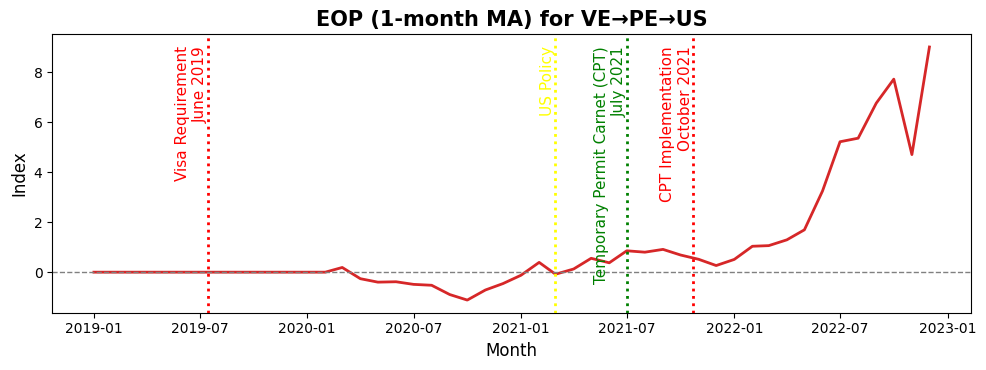

In [21]:
plot_triad_eop(
    eopPE,
    i="VE", j="PE", k="US",
    ma=1,
    policies=policies_PE,
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)

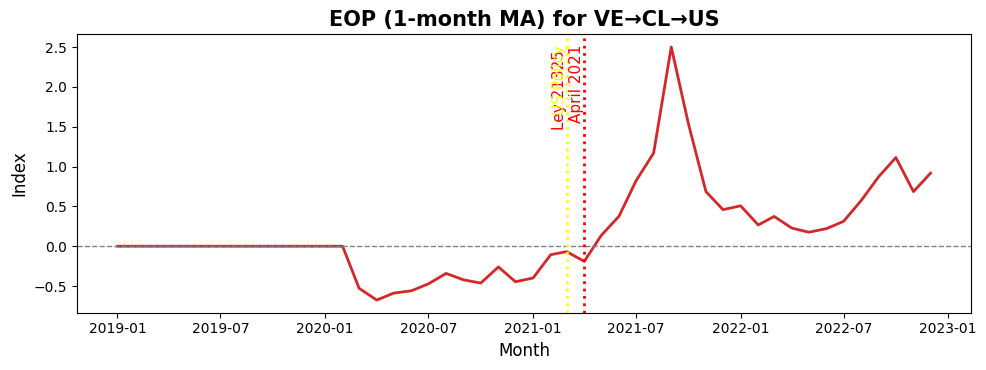

In [22]:
eopCL = eop[(eop['i'] == 'VE') & (eop['j'] == 'CL') & (eop['k'] == 'US')]

plot_triad_eop(
    eopCL,
    i="VE", j="CL", k="US",
    ma=1,
    policies=policies_CL,
    # policies=[("2022-03-01", "Policy Change", "tab:green")],
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)

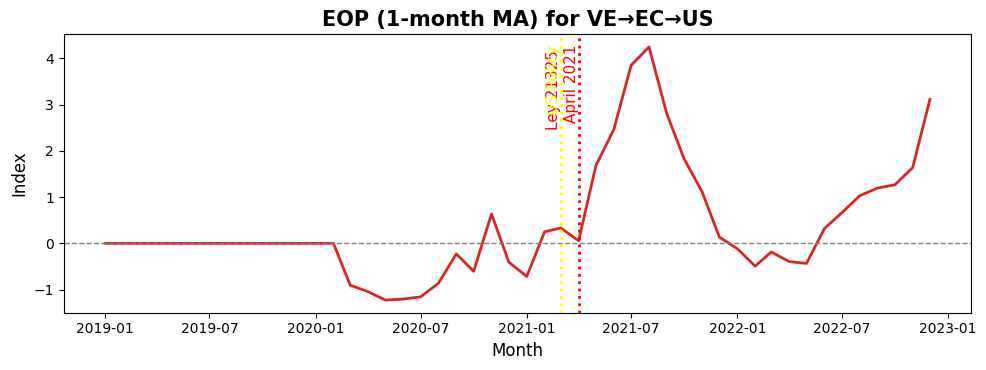

In [23]:
eopCL = eop[(eop['i'] == 'VE') & (eop['j'] == 'EC') & (eop['k'] == 'US')]

plot_triad_eop(
    eopCL,
    i="VE", j="EC", k="US",
    ma=1,
    policies=policies_CL,
    # policies=[("2022-03-01", "Policy Change", "tab:green")],
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)

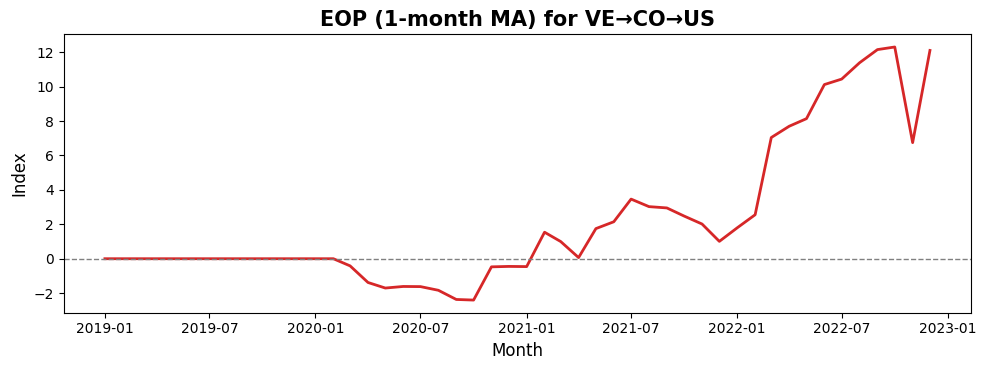

In [24]:
eopCL = eop[(eop['i'] == 'VE') & (eop['j'] == 'CO') & (eop['k'] == 'US')]

plot_triad_eop(
    eopCL,
    i="VE", j="CO", k="US",
    ma=1,
    # policies=policies_CO,
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)

In [ ]:
# Usage example for eop_post_cf.py
# Inputs:
#   pred_path  -> your saved CF++ predictions with columns: orig, dest, month, flow, mu_hat
#   flows_path -> observed flows (same schema as in pred; used only for computing weights w)

import pandas as pd
from eop_post_cf import anomalies_from_pred, AnomalyConfig, WeightConfig, compute_eop

# ---- 1) Paths (EDIT THESE) ----
pred_path = "pred.csv"       # <-- replace with your file
flows_path = "flows.csv"     # <-- replace with your file
train_end = "2021-12-01"     # training window end used by CF++

# ---- 2) Load ----
pred = pd.read_csv(pred_path)
flows = pd.read_csv(flows_path)

# ---- 3) Anomalies (Z or percent excess) ----
anom_cfg = AnomalyConfig(train_end=train_end, eps=1.0, use_standardized=True)  # Z by default
pred_anom = anomalies_from_pred(pred, anom_cfg)
print("Estimated phi_hat:", pred_anom.attrs.get('phi_hat'))

# ---- 4) Triads & windows ----
triads = [
    ("VEN","CHL","USA"),
    ("VEN","PER","USA"),
    ("VEN","ECU","USA"),
    # add more, e.g. ("HTI","DOM","USA"), ("SYR","TUR","DEU")
]

windows = [
    # Basic windows (no gating), with 3-month smoothing for w
    WeightConfig(window="m12_24", smooth_ma=3, gate_mode=None, train_end=train_end),
    WeightConfig(window="m6_18",  smooth_ma=3, gate_mode=None, train_end=train_end),
    WeightConfig(window="upto_12",smooth_ma=3, gate_mode=None, train_end=train_end),

    # Optional gating: only count w when the window-mean share is "unusually high"
    WeightConfig(window="m12_24", smooth_ma=3, gate_mode="zscore", z_thresh=1.0, train_end=train_end),
    # Or percentile-based gate (top 10% of baseline months)
    WeightConfig(window="m12_24", smooth_ma=3, gate_mode="percentile", perc_thresh=0.90, train_end=train_end),
]

# ---- 5) Compute EOP ----
eop = compute_eop(pred_anom, flows, triads, windows, anomaly_kind="z_std")  # or 'excess_pct'
eop.to_csv("eop_results.csv", index=False)
print("Saved: eop_results.csv")

# ---- 6) Quick summaries ----
# Peak month per triad & window
peaks = (eop.sort_values(['i','j','k','window','EOP'], ascending=[True,True,True,True,False])
           .groupby(['i','j','k','window'])
           .head(1)[['i','j','k','window','month','EOP']])
print("Peaks:")
print(peaks)

# 2022 annual means
eop['year'] = pd.to_datetime(eop['month']).dt.year
ann_2022 = (eop[eop['year']==2022]
            .groupby(['i','j','k','window'])['EOP']
            .mean()
            .reset_index()
            .sort_values(['i','j','k','window']))
print("2022 means:")
print(ann_2022)